In [1]:
from pathlib import Path

from astropy.io import fits
import h5py
from matplotlib import rc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from qso import lamost, utils

In [2]:
rc("font", family="serif")
rc("text", usetex=True)

In [3]:
LAMOST_DIR = Path("data") / "lamost"
LAMOST_DR5 = LAMOST_DIR / "lamost_dr5_v3"
LAMOST_CATALOG = LAMOST_DIR / "dr5_v3.fits"
LAMOST_COVERAGE = LAMOST_DIR / "lamost_dr5_v3_coverage.csv"
LAMOST_QSO_CATALOG = LAMOST_DIR / "lamost_phase1_v02.fits"
FIGS_DIR = Path("figs")

# LAMOST DR5 General Catalog

In [4]:
with fits.open(LAMOST_CATALOG) as catalog_hdul:
    catalog_hdul.info()
    catalog = catalog_hdul[1].data

Filename: data/lamost/dr5_v3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      17   ()      
  1                1 BinTableHDU    130   9026365R x 37C   [J, 19A, 10A, J, J, 40A, B, B, D, D, E, E, E, E, E, 16A, 20A, 20A, E, E, 25A, E, E, E, E, E, E, E, 16A, 10A, 60A, 60A, B, E, D, D, I]   


In [5]:
catalog["lmjd"].dtype, catalog["planid"].dtype, catalog["spid"].dtype, catalog["fiberid"].dtype

(dtype('>i4'), dtype('<U40'), dtype('uint8'), dtype('uint8'))

In [6]:
# LAMOST uses local modified julian date
np.all(catalog["lmjd"] - 1 == catalog["mjd"])

True

In [7]:
catalog_df = pd.read_csv(
    LAMOST_COVERAGE,
    index_col=["planid", "lmjd", "spid", "fiberid"],
    dtype={"wavemax": "f4", "wavemin": "f4"}
).sort_index()
catalog_df.info()
catalog_df.head()

/data/podondra/qso/venv/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9026365 entries, (B5591606, 55916, 1, 1) to (kepler08F56096, 56096, 16, 250)
Data columns (total 2 columns):
wavemax    float32
wavemin    float32
dtypes: float32(2)
memory usage: 129.2+ MB


wavemax      wavemin
planid   lmjd  spid fiberid                          
B5591606 55916 1    1        9099.134766  3699.986328
                    2        9099.134766  3699.986328
                    3        9099.134766  3699.986328
                    4        9099.134766  3699.986328
                    5        9099.134766  3699.986328

## Analysis

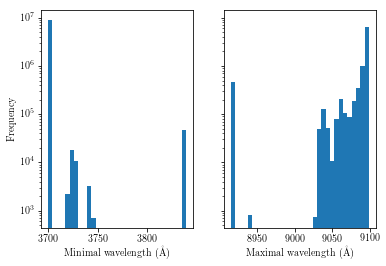

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
catalog_df["wavemin"].plot.hist(ax=ax1, bins=32, log=True)
catalog_df["wavemax"].plot.hist(ax=ax2, bins=32, log=True)
ax1.set_xlabel("Minimal wavelength (\AA{})")
ax2.set_xlabel("Maximal wavelength (\AA{})")
plt.savefig(str(FIGS_DIR / "wavemin_wavemax_hist.pdf"))

In [9]:
wavemin, wavemax = catalog_df["wavemin"].max(), catalog_df["wavemax"].min()
wavemax, np.log10(wavemax), wavemin, np.log10(wavemin)

(8914.597, 3.9501016, 3839.7244, 3.5843)

In [10]:
random_spec = catalog_df.sample().index[0]
with fits.open(LAMOST_DR5 / lamost.get_dr_path(*random_spec)) as hdul: 
    lam = hdul[0].data[2]
    loglam = np.log10(lam)
lam, loglam

(array([3699.9863, 3700.8384, 3701.6907, ..., 9094.945 , 9097.04  ,
        9099.135 ], dtype=float32),
 array([3.5682   , 3.5683002, 3.5684001, ..., 3.9588   , 3.9589002,
        3.959    ], dtype=float32))

# Full QSO Catalog

In [11]:
with fits.open(LAMOST_QSO_CATALOG) as qso_hdul:
    qso_hdul.info()
    qso_catalog = qso_hdul[1].data

Filename: data/lamost/lamost_phase1_v02.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    145   42552R x 64C   [J, 19A, D, D, J, 20A, J, J, D, J, D, J, D, J, D, D, D, D, D, D, D, D, J, D, J, D, D, D, D, D, D, D, J, D, J, D, D, D, D, D, D, D, J, D, J, D, D, D, D, D, D, J, D, J, D, D, D, D, D, D, D, D, D, A]   


In [12]:
qso_catalog["planid"].dtype, qso_catalog["mjd"].dtype, qso_catalog["spid"].dtype, qso_catalog["fiberid"].dtype

(dtype('<U20'), dtype('>i4'), dtype('>i4'), dtype('>i4'))

In [13]:
arrays = [
    list(x.strip() for x in qso_catalog["planid"]),
    qso_catalog["mjd"].astype("i4") + 1,
    qso_catalog["spid"].astype("i2"),
    qso_catalog["fiberid"].astype("i2"),
]
qso_multiindex = pd.MultiIndex.from_arrays(
    arrays, names=["planid", "lmjd", "spid", "fiberid"]
)

qso_missing = qso_multiindex.difference(catalog_df.index)
qso_multiindex = qso_multiindex.difference(qso_missing)
qso_multiindex.shape

(31755,)

In [14]:
catalog_df["qso"] = False
catalog_df.loc[qso_multiindex, "qso"] = True
catalog_df.head()

wavemax      wavemin    qso
planid   lmjd  spid fiberid                                 
B5591606 55916 1    1        9099.134766  3699.986328  False
                    2        9099.134766  3699.986328  False
                    3        9099.134766  3699.986328  False
                    4        9099.134766  3699.986328  False
                    5        9099.134766  3699.986328  False

# Dataset

In [15]:
EPS = 0.00005
N_TRAIN = 10 ** 6
N_VALID = 50000
SIZE = N_TRAIN + N_VALID

In [16]:
sample_df = catalog_df.sample(SIZE, random_state=28)
sample_df.iloc[:N_TRAIN]["qso"].sum(), sample_df.iloc[N_TRAIN:]["qso"].sum()

(3517, 190)